epoch_num=0: took 5.9741s. state:
{'1-pull_width**2': DeviceArray(0.14997934, dtype=float64),
 'CLs': DeviceArray(0.05885904, dtype=float64),
 'loss': DeviceArray(0.24811496, dtype=float64),
 'mu_uncert': DeviceArray(0.49811139, dtype=float64),
 'pull': DeviceArray([-0.09171364], dtype=float64),
 'pull_width': DeviceArray(0.61272833, dtype=float64),
 'yields': [DeviceArray([ 0.16475093, 10.57287479,  9.16472435,  0.0976359 ], dtype=float64),
            DeviceArray([ 0.51705293, 46.4369292 , 52.25306637,  0.79288196], dtype=float64),
            DeviceArray([ 1.36530154, 59.64468863, 38.70605926,  0.28380903], dtype=float64),
            DeviceArray([ 0.57750525, 48.32141814, 50.42568632,  0.67533104], dtype=float64)]}
epoch_num=1: took 5.7300s. state:
{'1-pull_width**2': DeviceArray(0.79476904, dtype=float64),
 'CLs': DeviceArray(0.02191363, dtype=float64),
 'loss': DeviceArray(0.20570452, dtype=float64),
 'mu_uncert': DeviceArray(0.4535466, dtype=float64),
 'pull': DeviceArray([0.301

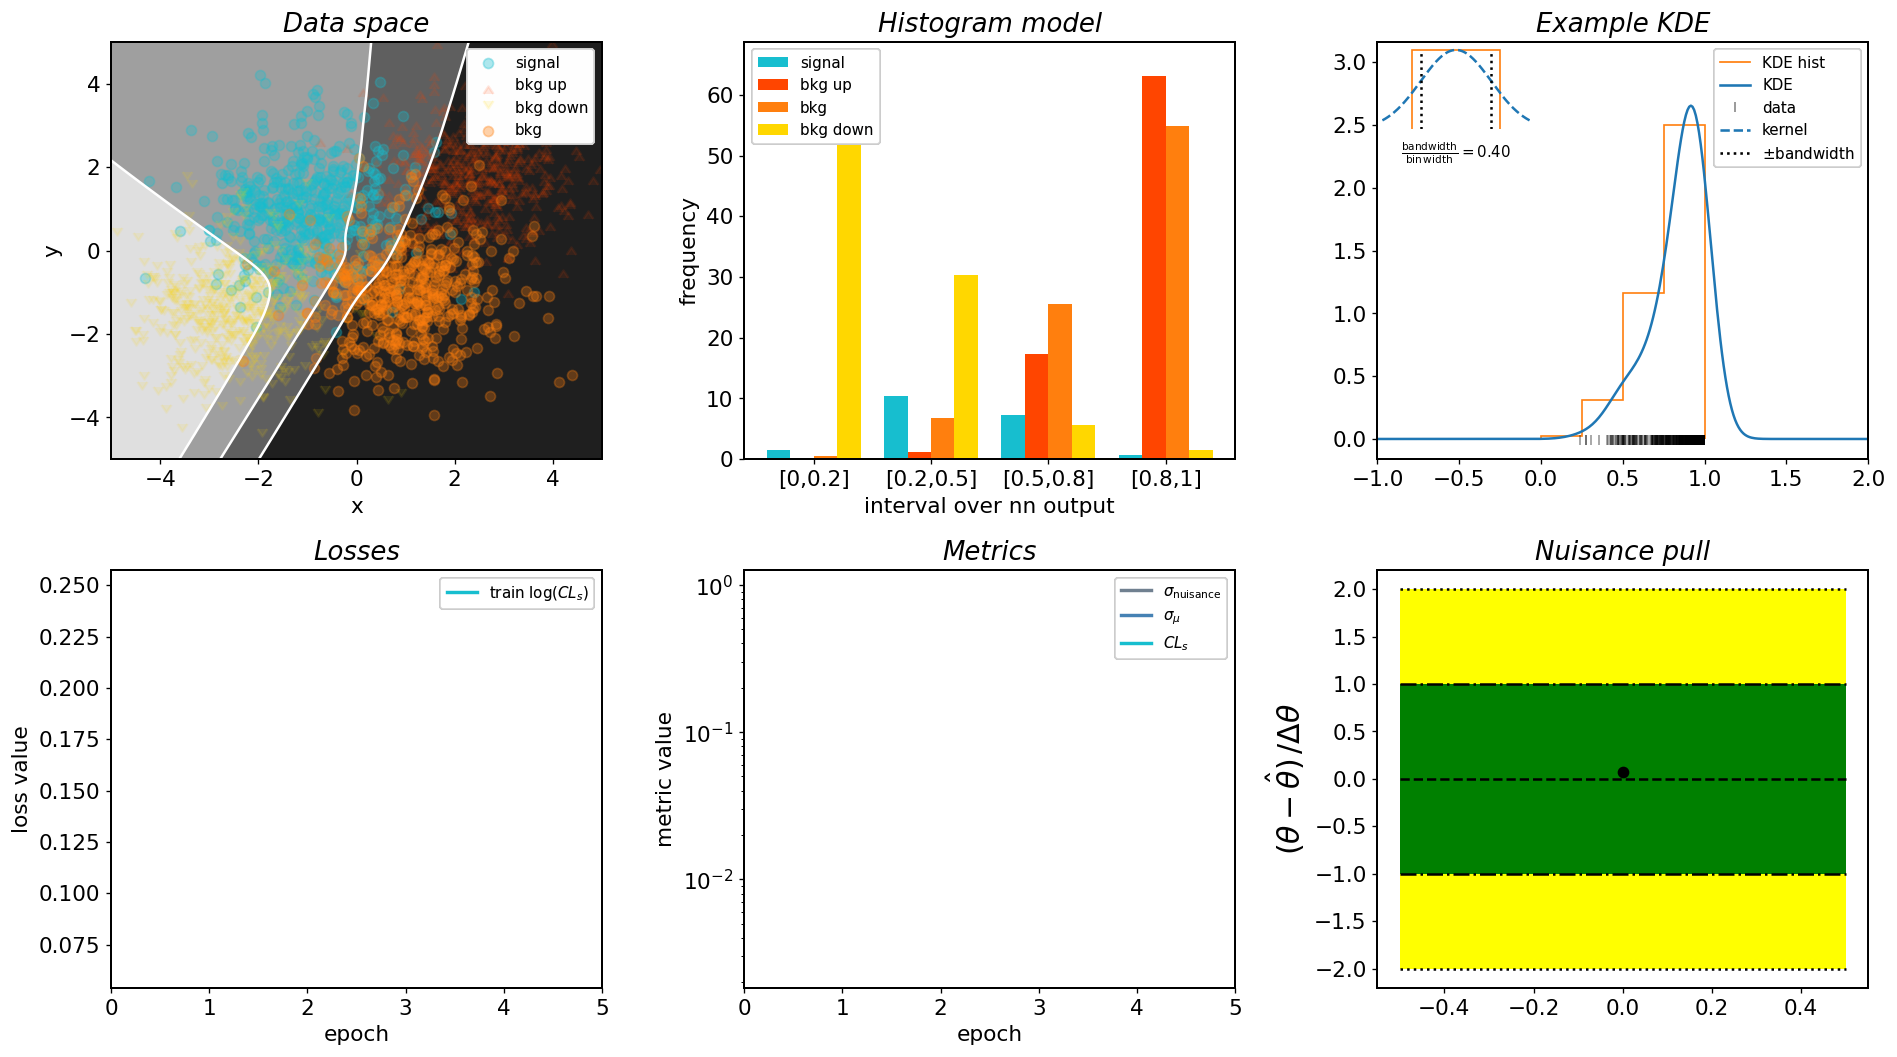

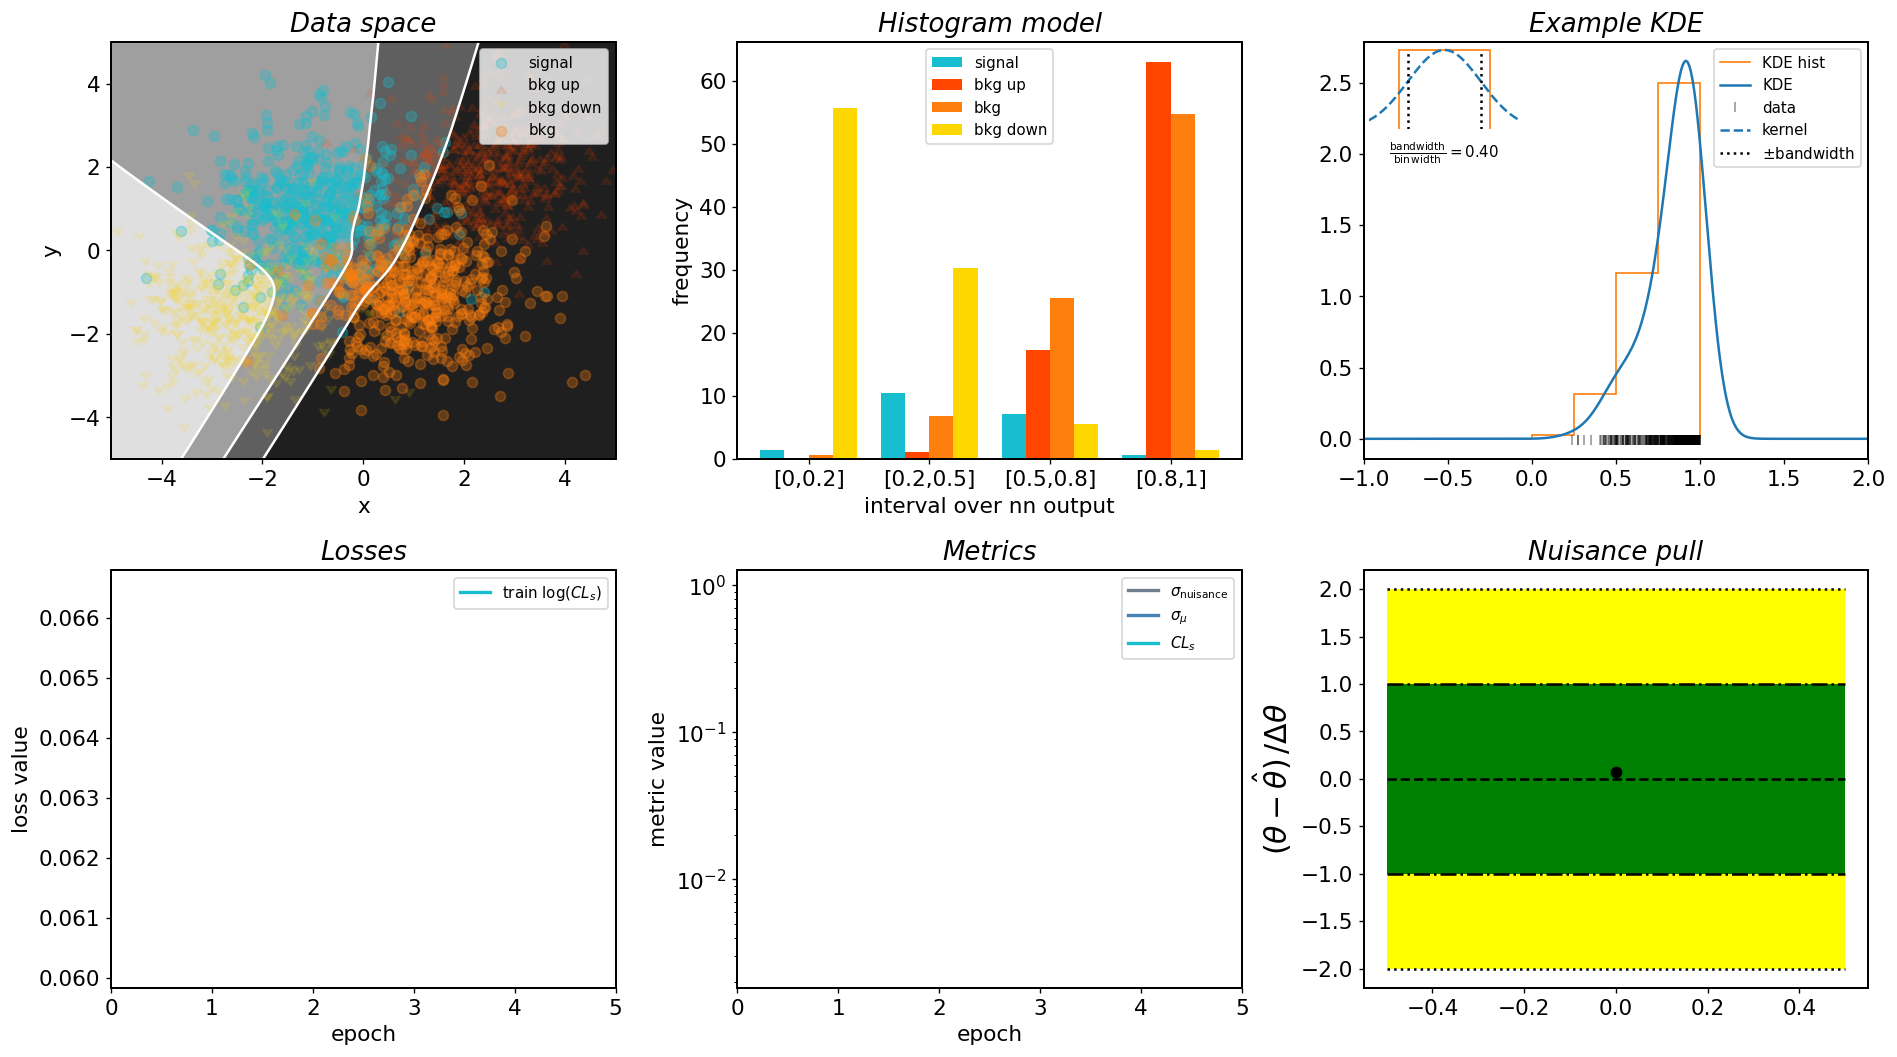

In [36]:
from __future__ import annotations

import relaxed
import jax
from jax import jit
from chex import Array
from typing import NamedTuple, Callable, Any
import pyhf
from sklearn.model_selection import train_test_split
from jax.random import PRNGKey, multivariate_normal
import numpy.random as npr
import optax
import jaxopt
import time
from functools import partial
from pprint import pprint


def make_model(s, b_nom, b_up, b_down):
    m = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": s,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None},
                        ],
                    },
                    {
                        "name": "background",
                        "data": b_nom,
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {"hi_data": b_up, "lo_data": b_down},
                            },
                        ],
                    },
                ],
            },
        ],
    }
    return pyhf.Model(m, validate=False)


def nn_summary_stat(
    pars, data, nn, bandwidth, bins, reflect=False, sig_scale=2, bkg_scale=10, LUMI=10
):
    s_data, b_nom_data, b_up_data, b_down_data = data

    nn_s, nn_b_nom, nn_b_up, nn_b_down = (
        nn(pars, s_data).ravel(),
        nn(pars, b_nom_data).ravel(),
        nn(pars, b_up_data).ravel(),
        nn(pars, b_down_data).ravel(),
    )

    num_points = len(s_data)

    yields = s, b_nom, b_up, b_down = [
        relaxed.hist(nn_s, bins, bandwidth, reflect_infinities=reflect)
        * sig_scale
        / num_points
        * LUMI,
        relaxed.hist(nn_b_nom, bins, bandwidth, reflect_infinities=reflect)
        * bkg_scale
        / num_points
        * LUMI,
        relaxed.hist(nn_b_up, bins, bandwidth, reflect_infinities=reflect)
        * bkg_scale
        / num_points
        * LUMI,
        relaxed.hist(
            nn_b_down,
            bins,
            bandwidth,
            reflect_infinities=reflect,
        )
        * bkg_scale
        / num_points
        * LUMI,
    ]

    return yields


@partial(
    jit, static_argnames=["model", "return_mle_pars", "return_constrained_pars"]
)  # forward pass
def hypotest(
    test_poi: float,
    data: Array,
    model: pyhf.Model,
    lr: float,
    bonly_pars: Array,
    return_constrained_pars: bool = False,
) -> tuple[Array, Array] | Array:
    # hard-code 1 as inits for now
    # TODO: need to parse different inits for constrained and global fits
    init_pars = jnp.asarray(model.config.suggested_init())[
        model.config.par_slice("correlated_bkg_uncertainty")
    ]
    conditional_pars = relaxed.mle.fixed_poi_fit(
        data, model, poi_condition=test_poi, init_pars=init_pars, lr=lr
    )
    mle_pars = bonly_pars
    profile_likelihood = -2 * (
        model.logpdf(conditional_pars, data)[0] - model.logpdf(mle_pars, data)[0]
    )

    poi_hat = mle_pars[model.config.poi_index]
    qmu = jnp.where(poi_hat < test_poi, profile_likelihood, 0.0)

    CLsb = 1 - pyhf.tensorlib.normal_cdf(jnp.sqrt(qmu))
    altval = 0.0
    CLb = 1 - pyhf.tensorlib.normal_cdf(altval)
    CLs = CLsb / CLb
    if return_constrained_pars:
        return CLs, conditional_pars
    else:
        return CLs


class Pipeline(NamedTuple):
    """Class to compose the pipeline for training a learnable summary statistic."""

    yields_from_pars: Callable[..., tuple[Array, ...]]
    model_from_yields: Callable[..., pyhf.Model]
    init_pars: Array
    data: Array | None = None
    yield_kwargs: dict[str, Any] | None = None
    nuisance_parname: str = "correlated_bkg_uncertainty"
    random_state: int = 0
    num_epochs: int = 20
    batch_size: int = 500
    learning_rate: float = 0.001
    optimizer: str = "adam"
    loss: Callable[[dict], float] = lambda x: x["CLs"]
    test_size: float = 0.2
    per_epoch_callback: Callable = lambda x: None
    first_epoch_callback: Callable = lambda x: None
    last_epoch_callback: Callable = lambda x: None
    post_training_callback: Callable = lambda x: None
    plot_setup: Callable = lambda x: None
    possible_metrics: tuple[str, ...] = (
        "CLs",
        "mu_uncert",
        "1-pull_width**2",
        "gaussianity",
    )
    animate: bool = True

    def run(self):
        pyhf.set_backend("jax", default=True)

        def pipeline(pars, data):
            yields = self.yields_from_pars(pars, data, **self.yield_kwargs)
            model = self.model_from_yields(*yields)
            state: dict[str, Any] = {}
            state["yields"] = yields
            bonly_pars = (
                jnp.asarray(model.config.suggested_init())
                .at[model.config.poi_index]
                .set(0.0)
            )
            data = jnp.asarray(model.expected_data(bonly_pars))
            state["CLs"], constrained = hypotest(
                1.0,
                data,
                model,
                return_constrained_pars=True,
                bonly_pars=bonly_pars,
                lr=1e-2,
            )
            uncerts = relaxed.cramer_rao_uncert(model, bonly_pars, data)
            state["mu_uncert"] = uncerts[model.config.poi_index]
            pull_width = uncerts[model.config.par_slice(self.nuisance_parname)][0]
            state["pull_width"] = pull_width
            state["1-pull_width**2"] = (1 - pull_width) ** 2
            # state["gaussianity"] = relaxed.gaussianity(model, bonly_pars, data, rng_key=PRNGKey(self.random_state))
            state["pull"] = jnp.array(
                [
                    (constrained - jnp.array(model.config.suggested_init()))[
                        model.config.par_order.index(k)
                    ]
                    / model.config.param_set(k).width()[0]
                    for k in model.config.par_order
                    if model.config.param_set(k).constrained
                ]
            )
            loss = self.loss(state)
            state["loss"] = loss
            return loss, state

        if self.data is not None:
            split = train_test_split(
                *self.data, test_size=self.test_size, random_state=self.random_state
            )
            train, test = split[::2], split[1::2]

            num_train = train[0].shape[0]
            num_complete_batches, leftover = divmod(num_train, self.batch_size)
            num_batches = num_complete_batches + bool(leftover)

            # batching mechanism
            def data_stream():
                rng = npr.RandomState(self.random_state)
                while True:
                    perm = rng.permutation(num_train)
                    for i in range(num_batches):
                        batch_idx = perm[
                            i * self.batch_size : (i + 1) * self.batch_size
                        ]
                        yield [points[batch_idx] for points in train]

            batches = data_stream()
        else:

            def blank_data():
                while True:
                    yield None

            batches = blank_data()

        solver = jaxopt.OptaxSolver(
            fun=pipeline, opt=optax.adam(self.learning_rate), has_aux=True
        )
        params, state = solver.init(self.init_pars)

        plot_kwargs = self.plot_setup(self)

        for epoch_num in range(self.num_epochs):
            batch_data = next(batches)
            print(f"{epoch_num=}: ", end="")
            start = time.perf_counter()
            params, state = solver.update(params=params, state=state, data=batch_data)
            end = time.perf_counter()
            t = end - start
            print(f"took {t:.4f}s. state:")
            pprint(state.aux)
            if epoch_num == 0:
                plot_kwargs["camera"] = self.first_epoch_callback(
                    params,
                    this_batch=batch_data,
                    metrics=state.aux,
                    maxN=self.num_epochs,
                    **self.yield_kwargs,
                    **plot_kwargs,
                )
            elif epoch_num == self.num_epochs - 1:
                plot_kwargs["camera"] = self.last_epoch_callback(
                    params,
                    this_batch=batch_data,
                    metrics=state.aux,
                    maxN=self.num_epochs,
                    **self.yield_kwargs,
                    **plot_kwargs,
                )
            else:
                plot_kwargs["camera"] = self.per_epoch_callback(
                    params,
                    this_batch=batch_data,
                    metrics=state.aux,
                    maxN=self.num_epochs,
                    **self.yield_kwargs,
                    **plot_kwargs,
                )
        if self.animate:
            plot_kwargs["camera"].animate().save(
                "animation.gif", writer="imagemagick", fps=8
            )


from jax.example_libraries import stax
import jax.numpy as jnp

rng_state = 0


def gen_blobs(
    rng=PRNGKey(rng_state),
    num_points=10000,
    sig_mean=jnp.asarray([-1, 1]),
    bup_mean=jnp.asarray([2.5, 2]),
    bdown_mean=jnp.asarray([-2.5, -1.5]),
    b_mean=jnp.asarray([1, -1]),
):
    sig = multivariate_normal(
        rng, sig_mean, jnp.asarray([[1, 0], [0, 1]]), shape=(num_points,)
    )
    bkg_up = multivariate_normal(
        rng, bup_mean, jnp.asarray([[1, 0], [0, 1]]), shape=(num_points,)
    )
    bkg_down = multivariate_normal(
        rng, bdown_mean, jnp.asarray([[1, 0], [0, 1]]), shape=(num_points,)
    )

    bkg_nom = multivariate_normal(
        rng, b_mean, jnp.asarray([[1, 0], [0, 1]]), shape=(num_points,)
    )
    return sig, bkg_nom, bkg_up, bkg_down


init_random_params, nn = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1),
    stax.Sigmoid,
)

_, init_pars = init_random_params(PRNGKey(rng_state), (-1, 2))

p = Pipeline(
    yields_from_pars=nn_summary_stat,
    model_from_yields=make_model,
    init_pars=init_pars,
    data=gen_blobs(),
    yield_kwargs=dict(nn=nn, bandwidth=1e-1, bins=jnp.linspace(0, 1, 5)),
    random_state=rng_state,
    loss=lambda x: x["CLs"],
    first_epoch_callback=first_epoch,
    last_epoch_callback=last_epoch,
    per_epoch_callback=per_epoch,
    plot_setup=mpl_setup,
    num_epochs=5,
)
p.run()

In [34]:
import jax.scipy as jsp
import matplotlib.pyplot as plt
import numpy as np


def make_kde(data, bw):
    @jax.jit
    def get_kde(x):
        return jnp.mean(
            jsp.stats.norm.pdf(x, loc=data.reshape(-1, 1), scale=bw), axis=0
        )

    return get_kde


def bar_plot(
    ax, data, colors=None, total_width=0.8, single_width=1, legend=True, bins=None
):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(
                x + x_offset,
                y,
                width=bar_width * single_width,
                color=colors[i % len(colors)],
            )

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    labels = [f"[{a:.1g},{b:.1g}]" for a, b in zip(bins[:-1], bins[1:])]
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys(), fontsize="x-small")


def plot(
    network,
    axs,
    axins,
    metrics,
    maxN,
    this_batch,
    nn,
    bins,
    bandwidth,
    legend=False,
    reflect=False,
):
    ax = axs["Data space"]
    g = np.mgrid[-5:5:101j, -5:5:101j]
    if jnp.inf in bins:
        levels = bins[1:-1]  # infinite
    else:
        levels = bins
    ax.contourf(
        g[0],
        g[1],
        nn(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        levels=levels,
        cmap="binary",
    )
    ax.contour(
        g[0],
        g[1],
        nn(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 1)[:, :, 0],
        colors="w",
        levels=levels,
    )
    sig, bkg_nom, bkg_up, bkg_down = this_batch

    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9", label="signal")
    ax.scatter(
        bkg_up[:, 0], bkg_up[:, 1], alpha=0.1, c="orangered", marker=6, label="bkg up"
    )
    ax.scatter(
        bkg_down[:, 0], bkg_down[:, 1], alpha=0.1, c="gold", marker=7, label="bkg down"
    )
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1", label="bkg")

    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if legend:
        ax.legend(fontsize="x-small", loc="upper right")
    ax = axs["Losses"]
    # ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="C9", linewidth=2.0, label=r"train $\log(CL_s)$")
    # ax.plot(metrics["test_loss"], c="C4", linewidth=2.0, label=r"test $\log(CL_s)$")
    # ax.set_yscale("log")
    # ax.set_ylim(1e-4, 0.06)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"loss value")
    if legend:
        ax.legend(fontsize="x-small", loc="upper right")

    ax = axs["Metrics"]
    ax.plot(
        metrics["1-pull_width**2"],
        c="slategray",
        linewidth=2.0,
        label=r"$\sigma_{\mathsf{nuisance}}$",
    )
    ax.plot(metrics["mu_uncert"], c="steelblue", linewidth=2.0, label=r"$\sigma_\mu$")
    ax.plot(metrics["CLs"], c="C9", linewidth=2, label=r"$CL_s$")
    # ax.set_ylim(1e-4, 0.06)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_yscale("log")
    ax.set_ylabel(r"metric value")
    if legend:
        ax.legend(fontsize="x-small", loc="upper right")

    ax = axs["Histogram model"]
    s, b, bup, bdown = metrics["yields"]

    if jnp.inf in bins:
        noinf = bins[1:-1]
        bin_width = 1 / (len(noinf) - 1)
        centers = noinf[:-1] + np.diff(noinf) / 2.0
        centers = jnp.array([noinf[0] - bin_width, *centers, noinf[-1] + bin_width])

    dct = {
        "signal": s,
        "bkg up": bup,
        "bkg": b,
        "bkg down": bdown,
    }

    bar_plot(
        ax,
        dct,
        colors=["C9", "orangered", "C1", "gold"],
        total_width=0.8,
        single_width=1,
        legend=legend,
        bins=bins,
    )
    ax.set_ylabel("frequency")
    ax.set_xlabel("interval over nn output")

    ax = axs["Nuisance pull"]

    pulls = metrics["pull"]
    pullerr = metrics["pull_width"]

    ax.set_ylabel(r"$(\theta - \hat{\theta})\,/ \Delta \theta$", fontsize=18)

    # draw the +/- 2.0 horizontal lines
    ax.hlines([-2, 2], -0.5, len(pulls) - 0.5, colors="black", linestyles="dotted")
    # draw the +/- 1.0 horizontal lines
    ax.hlines([-1, 1], -0.5, len(pulls) - 0.5, colors="black", linestyles="dashdot")
    # draw the +/- 2.0 sigma band
    ax.fill_between([-0.5, len(pulls) - 0.5], [-2, -2], [2, 2], facecolor="yellow")
    # drawe the +/- 1.0 sigma band
    ax.fill_between([-0.5, len(pulls) - 0.5], [-1, -1], [1, 1], facecolor="green")
    # draw a horizontal line at pull=0.0
    ax.hlines([0], -0.5, len(pulls) - 0.5, colors="black", linestyles="dashed")

    ax.scatter(range(len(pulls)), pulls, color="black")
    # and their uncertainties
    ax.errorbar(
        range(len(pulls)),
        pulls,
        color="black",
        xerr=0,
        yerr=pullerr,
        marker=".",
        fmt="none",
    )

    ax = axs["Example KDE"]
    b_data = bkg_nom
    d = np.array(nn(network, b_data).ravel().tolist())
    kde = make_kde(d, bandwidth)
    yields = b
    ls = [-1, 2]
    x = np.linspace(ls[0], ls[1], 300)
    db = jnp.array(jnp.diff(bins), float)  # bin spacing
    yields = yields / db / yields.sum(axis=0)  # normalize to bin width
    if jnp.inf in bins:
        pbins = [ls[0], *noinf, ls[1]]
    else:
        pbins = bins
    ax.stairs(yields, pbins, label="KDE hist", color="C1")
    if reflect:
        ax.plot(x, 2 * jnp.abs(kde(x)), label="KDE", color="C0")
    else:
        ax.plot(x, kde(x), label="KDE", color="C0")

    ax.set_xlim(*ls)

    # rug plot of the data
    ax.plot(
        d,
        jnp.zeros_like(d) - 0.01,
        "|",
        linewidth=3,
        alpha=0.4,
        color="black",
        label="data",
    )

    if legend:
        if jnp.inf in bins:

            width = jnp.diff(noinf)[0]
        else:
            width = jnp.diff(bins)[0]
        xlim = (
            [(width / 2) - (1.1 * bandwidth), (width / 2) + (1.1 * bandwidth)]
            if (width / 2) - bandwidth < 0
            else [-width / 3, width + width / 3]
        )
        axins.stairs([1], [0, width], color="C1")
        y = jnp.linspace(xlim[0], xlim[1], 300)
        demo = jsp.stats.norm.pdf(y, loc=width / 2, scale=bandwidth)
        axins.plot(y, demo / max(demo), color="C0", linestyle="dashed", label="kernel")
        # draw two vertical lines at ((width/2)-bandwidth)/2 and ((width/2)+bandwidth)/2
        axins.vlines(
            [(width / 2) - bandwidth, (width / 2) + bandwidth],
            0,
            1,
            colors="black",
            linestyles="dotted",
            label=r"$\pm$bandwidth",
        )
        # write text in the middle of the vertical lines with the value of the bandwidth
        ratio = bandwidth / width
        axins.text(
            width / 2,
            -0.3,
            r"$\mathsf{\frac{bandwidth}{bin\,width}}=$" + f"{ratio:.2f}",
            ha="center",
            va="center",
            size="x-small",
        )

        axins.set_xlim(*xlim)

        handles, labels = ax.get_legend_handles_labels()
        handles1, labels1 = axins.get_legend_handles_labels()
        ax.legend(
            handles + handles1, labels + labels1, loc="upper right", fontsize="x-small"
        )

In [21]:
def first_epoch(
    network,
    camera,
    axs,
    axins,
    metrics,
    maxN,
    this_batch,
    nn,
    bins,
    bandwidth,
    **kwargs,
):
    plot(
        axs=axs,
        axins=axins,
        network=network,
        metrics=metrics,
        maxN=maxN,
        this_batch=this_batch,
        nn=nn,
        bins=bins,
        bandwidth=bandwidth,
        legend=True,
    )
    plt.tight_layout()
    camera.snap()
    return camera


def last_epoch(
    network,
    camera,
    axs,
    axins,
    metrics,
    maxN,
    this_batch,
    nn,
    bins,
    bandwidth,
    **kwargs,
):
    plot(
        axs=axs,
        axins=axins,
        network=network,
        metrics=metrics,
        maxN=maxN,
        this_batch=this_batch,
        nn=nn,
        bins=bins,
        bandwidth=bandwidth,
    )
    plt.tight_layout()
    camera.snap()
    fig2, axs2 = plt.subplot_mosaic(
        [
            ["Data space", "Histogram model", "Example KDE"],
            ["Losses", "Metrics", "Nuisance pull"],
        ]
    )

    for label, ax in axs2.items():
        ax.set_title(label, fontstyle="italic")
    axins2 = axs2["Example KDE"].inset_axes([0.01, 0.79, 0.3, 0.2])
    axins2.axis("off")
    plot(
        axs=axs2,
        axins=axins2,
        network=network,
        metrics=metrics,
        maxN=maxN,
        this_batch=this_batch,
        nn=nn,
        bins=bins,
        bandwidth=bandwidth,
        legend=True,
    )
    plt.tight_layout()
    fig2.savefig(f"random.pdf")
    return camera


def per_epoch(
    network,
    camera,
    axs,
    axins,
    metrics,
    maxN,
    this_batch,
    nn,
    bins,
    bandwidth,
    **kwargs,
):
    plot(
        axs=axs,
        axins=axins,
        network=network,
        metrics=metrics,
        maxN=maxN,
        this_batch=this_batch,
        nn=nn,
        bins=bins,
        bandwidth=bandwidth,
    )
    plt.tight_layout()
    camera.snap()
    return camera


from celluloid import Camera


def mpl_setup(pipeline):
    plt.style.use("default")

    plt.rcParams.update(
        {
            "axes.labelsize": 13,
            "axes.linewidth": 1.2,
            "xtick.labelsize": 13,
            "ytick.labelsize": 13,
            "figure.figsize": [16.0, 9.0],
            "font.size": 13,
            "xtick.major.size": 3,
            "ytick.major.size": 3,
            "legend.fontsize": 11,
        }
    )

    plt.rc("figure", dpi=120)

    fig, axs = plt.subplot_mosaic(
        [
            ["Data space", "Histogram model", "Example KDE"],
            ["Losses", "Metrics", "Nuisance pull"],
        ]
    )

    for label, ax in axs.items():
        ax.set_title(label, fontstyle="italic")
    axins = axs["Example KDE"].inset_axes([0.01, 0.79, 0.3, 0.2])
    axins.axis("off")
    ax_cpy = axs
    axins_cpy = axins
    if pipeline.animate:
        camera = Camera(fig)
    return dict(
        camera=camera, axs=axs, axins=axins, ax_cpy=ax_cpy, axins_cpy=axins_cpy, fig=fig
    )